In [159]:
import tweepy
import requests
import os
from bing_image_downloader import downloader
import re
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageStat
from pathlib import Path
import shutil

In [ ]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN = ""
ACCESS_SECRET = ""

In [161]:
# Sets up the Twitter API
def getAPI():
    
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    api = tweepy.API(auth)

    return api


# Populates an empty dictionary with tweets
def get_tweets(verbose):
    
    tweet_dict = {}  # initialize dictionary for tweets
    count = 0
    api = getAPI()
    # API.search_tweets(q, *, geocode, lang, locale, result_type, count, until, since_id, max_id, include_entities)
    dream_tweets = api.search_tweets('dream', count=10) # change back to 100 later, for testing just use small number
    for tweet in dream_tweets:
        if(len(tweet.user.location) != 0):
            tweet_dict[count] = {'location': tweet.user.location, 'id': tweet.id, 'profile_url': tweet.user.profile_image_url, \
                                 'text': tweet.text, 'geo': tweet.geo, 'source': tweet.source, 'created_at': tweet.created_at, \
                                'lang': tweet.lang }
            
            count += 1
    
    if verbose == True:
        print("number of tweets: "+ str(count))
    
    return tweet_dict

In [162]:
# Downloads satellite images from Bing of location from Tweet

def get_satellite_image(tweet):

    location = tweet['location']

    # note: if 'location' contains special characters, might throw error for creation of directory in dataset
    escaped = re.sub(r"[^a-zA-Z0-9 ]", "", location) # note: cleans out non-English
    location = escaped
    tweet['location'] = location # location string updated for referencing dir later
    
    query_string = location + ' satellite map'
    
    # check and clear old dataset if exists
    dirpath = Path('dataset') / str(query_string)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    
    downloader.download(query_string, limit=3, output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60, verbose=False)
 
    return 

In [163]:
# Downloads twitter user's profile picture given tweet and count number 
def get_twitter_profile(tweet, count):    
    
    image_url = tweet['profile_url']
    img_data = requests.get(image_url).content
    
    # downloads to 'profile' directory
    while True:
        try:
            with open('./profile/' + str(count) + '.png', 'wb') as handler:
                handler.write(img_data)
            break
        except:
            print("Oops! Twitter profile img failed to download. ")
    
    return 1

# combines the satellite image and user profile associated with a tweet
def combine_images(tweet, count, isCrop): # boolean for 'isCrop'
        
    image = Image.open('./profile/' + str(count) + '.png') 
    image = image.resize((1000,1000))
    
    # image 2: open satellite map from folder
    query_string = tweet['location'] + ' satellite map'
    path = os.path.join("dataset", query_string) # folder path
    dir_list = os.listdir(path)
    path = os.path.join("dataset", query_string, dir_list[0]) # image 1 in folder path
    satelliteIm = Image.open(path)
    satelliteIm = satelliteIm.resize((1000,1000))
    
    if isCrop == True:
        image = crop_most_edges(image, False)
        satelliteIm = crop_most_edges(satelliteIm, False)    
 
   # convert images to ' ' mode
    image = image.convert('RGBA')
    satelliteIm = satelliteIm.convert('RGBA')
 
    # alpha is 0.5, 
    im3 = Image.blend(image, satelliteIm, 0.5)
 
    # return combined image
    return im3
        

In [164]:
# edge detection, crop based on which section has most edges
def crop_most_edges(image, verbose):

    # Converting the image to grayscale, as edge detection
    # requires input image to be of mode = Grayscale (L)
    image = image.convert("L")
    imageWithEdges = image.filter(ImageFilter.FIND_EDGES)

    # crop options
    left, top, right, bottom = 0, 0, 1000, 400 # top half
    crop_1 = imageWithEdges.crop((left, top, right, bottom))

    left, top, right, bottom = 0, 400, 1000, 800 # middle half
    crop_2 = imageWithEdges.crop((left, top, right, bottom))
    
    left, top, right, bottom = 0, 600, 1000, 1000 # bottom half
    crop_3 = imageWithEdges.crop((left, top, right, bottom))

    # calculate stats
    stat_1 = ImageStat.Stat(crop_1)
    stat_2 = ImageStat.Stat(crop_2)
    stat_3 = ImageStat.Stat(crop_3)
    stat = ImageStat.Stat(imageWithEdges)
    if verbose == True:
        print("crop_1: " + str(stat_1.mean))
        print("crop_2: " + str(stat_2.mean))
        print("crop_3: " + str(stat_3.mean))
    
    # decide which crop option to use
    option = max(stat_1.mean[0], stat_2.mean[0], stat_3.mean[0])
    if option == stat_2:
        image = image.crop((0, 400, 1000, 800)) # middle pt
    elif option == stat_1:
        image = image.crop((0, 0, 1000, 400)) # top pt
    else:
        image = image.crop((0, 600, 1000, 1000)) # bottom pt
    
    return image


In [165]:
#  Call draw Method to add 2D graphics in an image

def add_text(image, tweet):
    
    imageNew = ImageDraw.Draw(image)
    
    # Custom font style and font size
    myFont = ImageFont.truetype('simsun.ttc', 30)
    
    # Add Text to an image
    imageNew.text((10, 10), tweet['location'], font=myFont, fill =(0, 0, 255)) # text is location name
    imageNew.text((10, 50), tweet['text'], font=myFont, fill =(0, 0, 255))
    imageNew.text((10, 90), str(tweet['created_at']), font=myFont, fill =(0, 0, 255))

    return image

In [166]:
# # Runs program on a single tweet
# inputs, # of tickets to print, # of tweets to collect

# populates dictionary with tweets
tweet_dict = get_tweets(True)

# downloads satellite image given one tweet
get_satellite_image(tweet_dict[0])

# downloads twitter user profile picture
get_twitter_profile(tweet_dict[0], 0)

# combines the two images
image = combine_images(tweet_dict[0], 0, True)

# give image path and tweet to add text 
image = add_text(image, tweet_dict[0])
image.show()

# converting to jpg
rgb_im = image.convert("RGB")
rgb_im.save("ticket.jpg")
 

number of tweets: 2
[%] Downloading Images to C:\Users\minzhili\Documents\GitHub\pixel_art\dataset\Ankara Turkey satellite map


[%] Done. Downloaded 3 images.
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to downl

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter

Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 
Oops! Twitter profile img failed to download. 


KeyboardInterrupt: 

In [30]:
import math
from skimage import io, color
from skimage.transform import resize
import numpy as np

from numpy import array
from sklearn.decomposition import PCA
import cv2

In [31]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [32]:
# A class to initialize the super pixels, of the form - [h,w,l,a,b].
class SuperPixels(object):

    def __init__(self, h, w, r, c, l=0, a=0, b=0):
        self.update(h, w, r, c, l, a, b)
        self.pixels = [] # tracks associated input pixels

    def update(self, h, w, r, c, l, a, b):
        self.h = h
        self.w = w
        self.r = r # row in initial grid
        self.c = c # column in initial grid
        self.l = l
        self.a = a
        self.b = b
        

In [33]:
# returns an object of class SuperPixel
def make_superPixel(h, w, img, r, c):
    return SuperPixels(h, w, r, c, img[h,w][0],img[h,w][1],img[h,w][2])

In [34]:
# calculate gradient;  G(x,y) = ‖I(x+ 1,y)−I(x−1,y)‖²+‖I(x,y+ 1)−I(x,y−1)‖²
def calc_gradient(h, w,img,img_w,img_h):
    
    l = pow(img[h, w+1][0] - img[h, w - 1][0] , 2) #
    a = pow(img[h, w+1][1] - img[h, w - 1][1] , 2)
    b = pow(img[h, w+1][2] - img[h, w - 1][2] , 2)
    x_diff = math.sqrt(l + a + b)
    
    l = pow(img[h + 1, w][0] - img[h - 1, w][0] , 2)
    a = pow(img[h + 1, w][1] - img[h - 1, w][1] , 2)
    b = pow(img[h + 1, w][2] - img[h - 1, w][2] , 2)
    y_diff = math.sqrt(l + a + b)
    
    grad = x_diff + y_diff
    return grad

In [35]:
# reassign clusters based on gradient
def perturb_center(clusters, img):
    for c in clusters:
        center_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        w = c.w
        h = c.h
        for x in range(-1, 2):
            for y in range(-1, 2):
                W = w + x
                H = h + y
            
                if H == img_h or W == img_w: # might need to increase to H-1,W-1
                    new_gradient = math.inf
                else:
                    new_gradient = calc_gradient(H,W, img,img_w,img_h)
                    
                if new_gradient < center_gradient: # reassign to lower gradient position
                    c.update(H, W, c.r, c.c, img[H,W][0], img[H,W][1],img[H,W][2])
                    center_gradient = new_gradient # keeps track of lowest found in neighborhood so far

In [36]:
# Defines initial cluster centers distanced at S
def initial_cluster_center(S,img,img_h,img_w): 
    clusters = []
    h = S // 2 
    w = S // 2
    r = 0
    c = 0
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w, img, r, c))
            c += 1
            w += S
        w = S // 2
        h += S
        r += 1
        c = 0  
    return clusters

In [37]:
# replaces superpixel representative color w/ mean of the input pixels from a given bilateral filtered version
def update_mean_color(clusters, bilateral):
    new_means = []
    for c in clusters:
        sum_l, sum_a, sum_b = 0,0,0
        n = len(c.pixels)
        
        for p in c.pixels:           
            sum_l += bilateral[p[0],p[1]][0]
            sum_a += bilateral[p[0],p[1]][1]
            sum_b += bilateral[p[0],p[1]][2]
            
        avg_l = sum_l / n # don't use floor division for LAB values
        avg_a = sum_a / n
        avg_b = sum_b / n
        new_means.append([avg_l, avg_a, avg_b])
#         c.update(c.h, c.w, c.r, c.c, avg_l, avg_a, avg_b) # to be resolved
    return new_means # to be modified 

In [38]:
# replaces cluster center's (x,y) position w/ mean of the input pixels and avg. color
def update_cluster_mean(clusters, image):
    for c in clusters:
        sum_h = sum_w = number = 0
        sum_l, sum_a, sum_b = 0,0,0
        n = len(c.pixels)
        
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]            
            sum_l += image[p[0],p[1]][0]
            sum_a += image[p[0],p[1]][1]
            sum_b += image[p[0],p[1]][2]
            
        H = sum_h // n
        W = sum_w // n
        avg_l = sum_l / n # don't use floor division for LAB values
        avg_a = sum_a / n
        avg_b = sum_b / n
        c.update(H, W, c.r, c.c, avg_l, avg_a, avg_b)

In [39]:
# converts LAB images back to RGB and save it
def lab2rgb(path, lab_arr):
    rgb_arr = color.lab2rgb(lab_arr)
    io.imsave(path, rgb_arr)

In [40]:
# replace the color of each pixel in a cluster by the color of the cluster's center
# delete 
def avg_color_cluster(img,name,clusters):
    image = np.copy(img)
        
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # To change the color of cluster center to Black
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0        
        
    lab2rgb(name, image)

In [41]:
# assign pixels to center w/ best color & position proximity in a 2S x 2S neighborhood
def assign_pixels(clusters, S, img, img_h, img_w):
    
    prev = {} # tracks clusters found before best cluster identified
    
    # initialize the distance between pixels and cluster center as infinity
    dis = np.full((img_h, img_w), np.inf) 
    
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):       
            if h < 0 or h >= img_h: continue           # check image height boundaries
            for w in range(c.w - 2 * S, c.w + 2 * S):  # 2S x 2S neighborhood
                if w < 0 or w >= img_w: continue       # check image width boundaries
                l, a, b = img[h,w]                     # load input pixel
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Dp = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = Dc + (Dp * m / S) # don't use floor division
                # check if closest center found so far
                if D < dis[h,w]:
                    if (h, w) in prev:
                        prev[(h, w)].pixels.remove((h, w)) # removes an input pixel prev. associated w/ another cluster
                        prev[(h, w)] = c # re-assigned cluster
                        c.pixels.append((h, w))
                    else:
                        prev[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D 

In [43]:
# returns variance along principle component axis of a 2D array
# deprecated
# def pca_variance(arr, verbose):
#     # define a matrix
#     A = array(arr)
#     print(A)
#     # create the PCA instance
#     pca = PCA(3)
#     pca.fit(A)
    
#     if verbose == True:
#         # access values and vectors
#         print("fcomponents:")
#         print(pca.components_)
#         print("explained variance")
#         print(pca.explained_variance_)
    
#     return pca

In [44]:
# initialize color palette given specified size
def makePalette(size, initial_color):
    arr = np.zeros((size, 3))
    arr[0] = initial_color
    return arr

In [45]:
# Used during palette initialization
# assign superpixel to color in palette
def assign_color(clusters, palette, color):
    for c in clusters:
        c.l = palette[color][0]
        c.a = palette[color][1]
        c.b = palette[color][2]

In [46]:
# associate each superpixel w/ a palette color
def assign_pal_color(clusters, palette, pal_size):
    this_probs = []
    for c in clusters:
        c_prob = 0
        y = [] # store probabilities for each color 
        for count, p in enumerate(palette):
                        
            # calculate diff in LAB space
            norm = math.sqrt(math.pow(c.l - p[0], 2) + math.pow(c.a - p[1], 2) + math.pow(c.b - p[2], 2))
            x = (norm / T) * -1
            x = 2*x # test
            new_prob = math.pow(math.e, x) 
            y.append(new_prob)
                       
            # associate if largest probability found
            if new_prob > c_prob:
                c.l = p[0]
                c.a = p[1]
                c.b = p[2] # assigns superpixel w/ palette color 
                c_prob = new_prob # track latest greatest probability found so far    
            
        y = normalize_probs(y)
        this_probs.append(y)
            
#     print("pal this_probs:", this_probs)
    
    return this_probs

In [47]:
# normalize probabilities
# takes in an array of probabilities and makes sure they sum to 1
def normalize_probs(probs):
    norm_probs = []
    all_probs = sum(probs)
    for p in probs:
        x = p / all_probs
        norm_probs.append(x)
    return norm_probs

In [48]:
#refine color palette
def refine_pal(clusters, palette, size, new_means, probs): 
    
    # best way to refine palette?
    new_pal = []
    
    for i in range(size):
        # calculate weighted avg of superpixel colors to a palette color
        # sum up each product of superpixel's color and weight (associated probability)
        sum_l = 0
        sum_a = 0
        sum_b = 0
        sum_weights = 0.00001
        
        lst = get_clusters(clusters, probs)
        for count, c in enumerate(clusters): # get bilateral mean color
            if lst[count] == i:
                prob = probs[count][i] # associated probability
#             if prob > 0.5:
                l = new_means[count][0] * prob
                a = new_means[count][1] * prob
                b = new_means[count][2] * prob
#             else:
#                 prob = prob * 0.5
#                 l = new_means[count][0] * prob
#                 a = new_means[count][1] * prob
#                 b = new_means[count][2] * prob
            
                sum_l += l
                sum_a += a
                sum_b += b
                sum_weights += prob
        # weighted avg
        new_l = sum_l / sum_weights
        new_a = sum_a / sum_weights
        new_b = sum_b / sum_weights 
           
        new_pal.append([new_l, new_a, new_b])
    return new_pal

In [49]:
# get clusters associated with palette color
def get_clusters(clusters, probs):
    pal_indices = []
    for x in probs:
        an_array = np.array(x)
        index = np.argmax(an_array) # index of palette color
        pal_indices.append(index)
    return pal_indices

In [50]:
# checks if palette converged
def if_converg(prev_pal, palette):
#     tolerance = 0.01
    tolerance = 0.1
    diffs = []
    for count, p in enumerate(palette):       
        l = math.pow(prev_pal[count][0] - p[0], 2)
        a = math.pow(prev_pal[count][1] - p[1], 2)
        b = math.pow(prev_pal[count][2] - p[2], 2)
        diff = math.sqrt(l+a+b)
        diffs.append(diff)
    print("pal diff")
    print(max(diffs))
    if max(diffs) < tolerance: 
        return True
    else:
        return False

In [51]:
# laplacian smoothing: adjust superpixel center closer to avg of its 4-connected neighbors

def laplacian(clusters):
    x = len(clusters)
    row = clusters[x-1].r + 1 # number of rows
    col = clusters[x-1].c + 1 # number of columns
      
    for count, c in enumerate(clusters):

        # skip first and last row; # skip left and right column
        if c.r == 0 or c.r == (row-1):
            continue 
        if c.c == 0 or c.c == (col-1):
            continue    

        # get h & w from 4-connected neighbors
        lh, lw = clusters[count - 1].h, clusters[count - 1].w
        rh, rw = clusters[count + 1].h, clusters[count + 1].w
        th, tw = clusters[count - col].h, clusters[count - col].w
                
        bh, bw = clusters[count + col].h, clusters[count + col].w

        # calculate displacement
        x_avg = (lw + rw + tw + bw) / 4
        y_avg = (lh + rh + th + bh) / 4 
        x_diff = c.w - x_avg
        y_diff = c.h - y_avg

        # move center closer to avg 
        c.w = math.floor(c.w + (x_diff * 0.4))
        c.h = math.floor(c.h + (y_diff * 0.4))
        

In [52]:
# expand palette
def expand_pal(palette, size, new_means, probs):
    
    new_pal = []
    
    means_lst = run_means_assign(palette, new_means, probs) #
    
    # iterate over each color in palette
    for count, p in enumerate(palette):
        # get two centroids
        if not means_lst[count]: continue 
        if len(means_lst[count])==1: continue
        centers_lst = six_centroids(means_lst[count]) ##
    new_pal = centers_lst
#         x = centers_lst[0]
#         y = centers_lst[1]
        
#         l = math.pow(x[0] - y[0], 2)
#         a = math.pow(x[1] - y[1], 2)
#         b = math.pow(x[2] - y[2], 2)
#         diff = math.sqrt(l+a+b)

#         if diff > 10: # can adjust tolerance
#             # split
#             new_pal.append(x)
#             new_pal.append(y) 
#         else:
#             new_pal.append(p)

    return new_pal  

In [53]:
# calculates two centroids for a list of LAB colors
def six_centroids(data): 
    linkage_data = linkage(data, method='ward', metric='euclidean')
    dendrogram(linkage_data)
    hierarchical_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
    labels = hierarchical_cluster.fit_predict(data) 
    
    first_lst = []
    second_lst = []
    third = []
    four = []
    five = []
    six = []

    for count, l in enumerate(labels):
        if l == 0:
            first_lst.append(data[count])
        if l == 1:
            second_lst.append(data[count])
        if l == 2:
            third.append(data[count])
        if l == 3:
            four.append(data[count])
        if l == 4:
            five.append(data[count])
        if l == 5:
            six.append(data[count])

    x = np.array(first_lst)
    y = np.array(second_lst)

    centroid_1 = x.mean(axis=0) # centroid 1
    centroid_2 = y.mean(axis=0) # centroid 2
    c_3 = np.array(third).mean(axis=0)
    c_4 = np.array(four).mean(axis=0)
    c_5 = np.array(five).mean(axis=0)
    c_6 = np.array(six).mean(axis=0)
    
    centroids = []
    centroids.append(centroid_1)
    centroids.append(centroid_2)
    centroids.extend([c_3, c_4, c_5, c_6])
    # returns the centroids of the list 
    return centroids 

In [54]:
# run means_assign on each palette color
def run_means_assign(palette, new_means, probs):
    pal_means = []
    size = len(palette)
    for i in range(size):
        means = means_assign(i, new_means, probs)
        pal_means.append(means)
    # returns list of list of new means   
    return pal_means 

In [55]:
def means_assign(item_index, new_means, probs):
    means_lst = [] # stores items from new_means
    for count, x in enumerate(probs):
        an_array = np.array(x)
        index = np.argmax(an_array) # index of palette color
        
        if index == item_index: # superpixel was associated with this palette color
            means_lst.append(new_means[count])
        
    # returns sub-set of new_means for each palette color 
    return means_lst 

In [56]:
def pal_assigns(probs):
    assigns = []
    for count, x in enumerate(probs):
        an_array = np.array(x)
        index = np.argmax(an_array)
        assigns.append(index)
        
    # returns clusters palette color assignments 
    return assigns

In [57]:
# read the input RGB image
# rgb = io.imread("barack-2.jpg",plugin='matplotlib') # may take too much mem
rgb = io.imread("japan-small.jpg",plugin='matplotlib')
print(rgb.shape)

# convert RGB to LAB
img = color.rgb2lab(rgb)

k = 300   # Number of Super pixels, # adjust later, was 50
m = 45    # Constant for normalizing the color proximity, range of m = [1,40], # paper uses '45'

img_h = img.shape[0] # Image Height
img_w = img.shape[1] # Image Width

N = img_h * img_w  # Total number of pixels in the image
S = int(math.sqrt(N / k)) # initial length of one superpixel along one dimension

flat_img = img.reshape((N,3))

# Initialize T and color palette
pca = pca_variance(flat_img, True)
t = pca.explained_variance_[0] 
print("explained variance")
print(pca.explained_variance_)
# T = 1.1 * 2 * t
T = 1

average = flat_img.mean(axis=0) # avg color of input image
# average = img.mean(axis=0).mean(axis=0) # or
colors = 8 # user can change
palette = makePalette(1, average) # track palette colors
pal_size = 1 # initial palette size 1
print(palette)
image = np.copy(img)
# Apply bilateral filter with d = 15, 
# sigmaColor = sigmaSpace = 75.
bilateral = cv2.bilateralFilter(rgb, 15, 75, 75)
bilateral = color.rgb2lab(bilateral) # change to LAB space

(600, 600, 3)
[[ 2.19338797e+00 -1.39257019e-04  2.63961737e-04]
 [ 2.19338797e+00 -1.39257019e-04  2.63961737e-04]
 [ 2.19338797e+00 -1.39257019e-04  2.63961737e-04]
 ...
 [ 3.14798880e-01  4.33702381e-01 -1.98422326e+00]
 [ 3.14798880e-01  4.33702381e-01 -1.98422326e+00]
 [ 9.89341352e-02  6.95219098e-01 -1.89211773e+00]]
fcomponents:
[[ 0.69874791 -0.08878177  0.70983742]
 [ 0.7141013   0.02754238 -0.69950036]
 [ 0.04255227  0.99567023  0.08264436]]
explained variance
[438.85178851 322.34919617  34.45607173]
explained variance
[438.85178851 322.34919617  34.45607173]
[[ 22.92148803   1.83303148 -15.96875144]]


T
1
cycle0
1
[array([ 19.50713501,   2.35889883, -21.35256284]), array([45.20068888,  2.69794194, 34.79642502]), array([ 36.29011578,   3.91934481, -32.74902485]), array([ 3.56885053,  1.12877634, -7.36339093]), array([ 65.35856266,  -1.58643802, -24.50785224]), array([29.35799338, -4.53435792,  7.97964143])]
6
p-color assignments:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/tmp/ipykernel_632385/3884320758.py:4: UserWarning: japan_m45_k300_C-0.png is a low contrast image
  io.imsave(path, rgb_arr)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


cycle1
1
[array([48.13366859, 10.07254561, 41.47751185]), array([51.0760681 ,  7.49818048, 48.03751242]), array([80.68494937, -1.79738837, 78.1946078 ]), array([43.12929544,  5.0956019 , 36.37679529]), array([ 86.41977824,  -6.48453063, -16.65671354]), array([ 81.73468758,  -5.01365694, -19.5074724 ])]
6
p-color assignments:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 5, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


cycle2
1


ValueError: Cannot extract more clusters than samples: 6 clusters where given for a tree with 4 leaves.

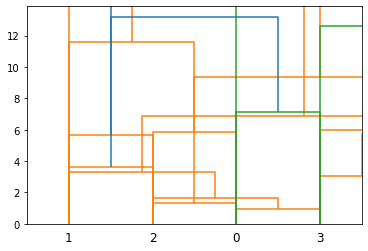

In [58]:
clusters = initial_cluster_center(S,img,img_h,img_w) # initialize superpixel clusters as a grid 
perturb_center(clusters, img) # perturb centers to lowest gradient position
assign_color(clusters, palette, 0) # initialize superpixels to first color in palette (avg)
print("T")
print(T)
cycle = 0
while T > 0:
    print("cycle"+str(cycle))
    # Refine superpixels w/ modified slic
    assign_pixels(clusters,S,img,img_h,img_w)
    update_cluster_mean(clusters, img)
    
    laplacian(clusters)
    new_means = update_mean_color(clusters, bilateral) 
    
    # Palette Iteration
    # associate superpixels to palette colors
    probs = assign_pal_color(clusters, palette, pal_size)
   
    # refine color palette
#     prev_pal = palette.copy() # copy palette to check for convergence in next step
#     print("prev pal:")
#     print(palette)
#     palette = refine_pal(clusters, palette, pal_size, new_means, probs)
#     print("refined pal:")
#     print(palette)
       
#     # check palette convergence
#     answer = if_converg(prev_pal, palette)
#     print(answer)
    answer = True 
    if answer == True:
        # reduce temperature by 30 percent
#         T = T * 0.7 # test
        print(T)
        # palette size limit reached?
        if pal_size == colors:
            
            break
            
        else: # expand palette / resolve splits for each color

            # inputs: list of {new means} associated with each existing cluster/Palette Color
            new_pal = expand_pal(palette, pal_size, new_means, probs)
            pal_size = len(new_pal)
            palette = new_pal
            print(new_pal)
            print(pal_size)
# if cycle == 6:
    assigns = pal_assigns(probs)
    print("p-color assignments:")
    print(assigns)
    name = 'japan_m{m}_k{k}_C-{c}.png'.format(m=m, k=k, c=cycle)
    avg_color_cluster(img,name,clusters)

    cycle += 1
        
# post process, up saturation 
name = 'pixel_out_m{m}_k{k}.png'.format(m=m, k=k)
avg_color_cluster(img,name,clusters)
    

In [ ]:
# superpixels
for c in clusters:
    print("H {} : W {}, l {}, a {}, b {}".format(c.h,c.w,c.l,c.a,c.b))